<a href="https://colab.research.google.com/github/benchov/AlgoTrading/blob/master/ALPACA_Statistical_Arbitrage_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PROJECT START

#### Ideas and notes


*Next Step*

1.   When a trade is open is would be great if the system collect the tickers of the opened positions and provide the cointegration candelstick chart with indicators, entry point line and stop loss line. The chart should be rely on the real time market data.


EXECUTION SESSION



1.   Configuration input variables
2.   Get real time market data

3.   Calculating entry point, stoploss and position size
4.   Get the actual opened position, show 






#### package installation

In [38]:
!pip install alpaca-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### imports

In [39]:
# imports
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import GetAssetsRequest
from alpaca.trading.enums import AssetClass, AssetStatus
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### global variables

In [40]:
# global variables
time_interval = 200
zscore_window = 21

#### keys and secrets

In [41]:
# API keys for Alpaca
API_KEY = 'PKJAMRGMC0EMO7LCX999'
SECRET_KEY = 'gRhoCnuCZ7qpzQkH1NRSMVQZXNGyNcurvrexeJEp'

In [42]:
# creating an instance of client
trading_client = TradingClient(API_KEY, SECRET_KEY, paper=True)

In [43]:
# test the availability of the api by account information
account = trading_client.get_account()
print(account)

id=UUID('d38ec6c2-a23b-4708-a064-cda26744e218') account_number='PA3OJP423MLE' status=<AccountStatus.ACTIVE: 'ACTIVE'> crypto_status=<AccountStatus.ACTIVE: 'ACTIVE'> currency='USD' buying_power='191435.13' regt_buying_power='191435.13' daytrading_buying_power='0' non_marginable_buying_power='95707.69' cash='99782.69' accrued_fees='0' pending_transfer_out=None pending_transfer_in='0' portfolio_value='99802.44' pattern_day_trader=False trading_blocked=False transfers_blocked=False account_blocked=False created_at=datetime.datetime(2022, 12, 22, 19, 56, 32, 73526, tzinfo=datetime.timezone.utc) trade_suspended_by_user=False multiplier='2' shorting_enabled=True equity='99802.44' last_equity='99767.49' long_market_value='4094.75' short_market_value='-4075' initial_margin='4084.875' maintenance_margin='3834.125' last_maintenance_margin='3847.64' sma='99817.19' daytrade_count=0


In [44]:
# get the available US equity stocks
search_params = GetAssetsRequest(asset_class=AssetClass.US_EQUITY, status=AssetStatus.ACTIVE)
assets = trading_client.get_all_assets(search_params)
asset_list = []
for i in assets:
  if i.shortable == True and i.tradable == True and i.fractionable == True:
    asset_list.append(i.symbol)
asset_list[:5],len(asset_list)

(['PAG', 'PAGP', 'STX', 'FCPT', 'LKNCY'], 3834)

In [45]:
assets[0]

{   'asset_class': <AssetClass.US_EQUITY: 'us_equity'>,
    'easy_to_borrow': False,
    'exchange': <AssetExchange.OTC: 'OTC'>,
    'fractionable': False,
    'id': UUID('7f00ea42-82b4-40b8-bc7f-feef41bbf355'),
    'maintenance_margin_requirement': 100.0,
    'marginable': False,
    'min_order_size': None,
    'min_trade_increment': None,
    'name': 'EQONEX LTD Ordinary Shares',
    'price_increment': None,
    'shortable': False,
    'status': <AssetStatus.ACTIVE: 'active'>,
    'symbol': 'EQOSQ',
    'tradable': False}

### GET DATA READY

In [46]:
# Get data from ALPACA server
symbol_client = StockHistoricalDataClient(API_KEY, SECRET_KEY)
multi_symbol_params = StockBarsRequest(symbol_or_symbols=asset_list[:1000], 
                                        timeframe=TimeFrame.Hour,
                                        start="2023-01-01 00:00:00"
                                        )
 
bars = symbol_client.get_stock_bars(multi_symbol_params)

# turn data into DataFrame
df_bars = bars.df

In [47]:
# DURING THE DEVELOPMENT PHASE REDUCING THE NUMBER OF STOCKS
# df_bars = df_bars.sample(frac=0.1)

In [48]:
tickers = df_bars.index.get_level_values(0).unique()

In [49]:
# removing those tickers which has not enough data to calculate cointegration
symbol_for_remove = []
for symbol in tickers:
  if len(df_bars.loc[symbol]) < 200:
      symbol_for_remove.append(symbol)
df_bars_cleared = df_bars.drop(symbol_for_remove, axis=0)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [50]:
print(f"{len(tickers) - len(symbol_for_remove)} ticker removed")

962 ticker removed


In [51]:
# create new updated ticker list
tickers_cleared = df_bars.index.get_level_values(0).unique()

# check filtered asset to shortable, tradable and fractianable
test_asset = trading_client.get_asset(tickers_cleared[10])
test_asset

{   'asset_class': <AssetClass.US_EQUITY: 'us_equity'>,
    'easy_to_borrow': True,
    'exchange': <AssetExchange.NASDAQ: 'NASDAQ'>,
    'fractionable': True,
    'id': UUID('2652df43-e5bd-4504-80f2-4d4d672090bd'),
    'maintenance_margin_requirement': 30.0,
    'marginable': True,
    'min_order_size': None,
    'min_trade_increment': None,
    'name': 'AbCellera Biologics Inc. Common Shares',
    'price_increment': None,
    'shortable': True,
    'status': <AssetStatus.ACTIVE: 'active'>,
    'symbol': 'ABCL',
    'tradable': True}

In [52]:
tickers_cleared

Index(['AAAU', 'AADI', 'AAC', 'AAIC', 'AAL', 'AAWW', 'AAT', 'AAPL', 'AA',
       'AAXJ',
       ...
       'YPF', 'ZEUS', 'ZETA', 'ZBH', 'ZIP', 'ZION', 'ZG', 'ZM', 'ZLAB', 'Z'],
      dtype='object', name='symbol', length=975)

In [53]:
len(tickers_cleared), len(df_bars_cleared)

(975, 352794)

#### !TASK: create a session report

This place where all #logs# would be inside one well organised report, not print after every cell.

### CALCULATING COINTEGRATION

##### handlers functions

In [54]:
def calculate_zscore (spread):
  df = pd.DataFrame(spread)
  mean = df.rolling(center=False, window=zscore_window).mean()
  std = df.rolling(center=False, window=zscore_window).std()
  x = df.rolling(center=False, window=1).mean()
  result = (x - mean) / std
  return result.astype(float)

def calculate_spread (series_1, series_2, hedge_ratio):
  '''
    series_1: Series which contains first assets close prices,
    series_2: Series which contains second assets close prices,
    hedge_ratio = It comes from the calculated cointegration dataframe

    returns: float
  '''
  spread = pd.Series(series_1) - (pd.Series(series_2) * hedge_ratio)
  return spread.astype(float)

def calculate_cointegration (series_1, series_2):
  coint_flag = 0
  coint_result = coint(series_1, series_2)
  coint_t = coint_result[0]
  p_value = coint_result[1]
  critical_value = coint_result[2][1]
  model = sm.OLS(series_1, series_2).fit()
  hedge_ratio = model.params[0]
  spread = calculate_spread(series_1, series_2, hedge_ratio)
  zero_crossings = len(np.where(np.diff(np.sign(spread)))[0])
  traded = 0

  if p_value < 0.5 and coint_t < critical_value:
    coint_flag = 1
  return (
      coint_flag, 
      round(p_value, 2),
      round(coint_t, 2), 
      round(critical_value, 2), 
      round(hedge_ratio, 2), 
      zero_crossings,
      traded)

def get_close_price(prices):
  # create a series with close prices but put the timestamp into it
  close_prices = list(prices.loc[:, 'close'])
  return close_prices

def get_cointegrated_pairs (data, ticker ):
  print('calculating cointegration....')
  # loop thorugh coins and check cointegration
  coint_pair_list = []
  included_list = []

  for sym_1 in ticker:
  #   # check each coin against the first  (sym_1) symbol
      for sym_2 in ticker:
        if sym_2 != sym_1: 

          # get unique asset combination if and ensure it is not duplicated
          sorted_asset_names = sorted(sym_1 + sym_2)
          unique = "".join(sorted_asset_names)
          if unique in included_list:
            break

          # Get close prices 
          series_1 = get_close_price(data.loc[sym_1])
          series_2 = get_close_price(data.loc[sym_2])


          # check cointegration and add result
          if len(series_1) > 200 and len(series_2) > 200:
            coint_flag, p_value, t_value, c_value, hedge_ratio, zero_crossing, traded = calculate_cointegration(series_1[:200], series_2[:200])

          if coint_flag == 1:
            included_list.append(unique)
            coint_pair_list.append({
                "sym_1": sym_1,
                "sym_2": sym_2,
                "coint_flag": coint_flag,
                "p_value": p_value,
                "t_value": t_value,
                "c_value": c_value,
                "hedge_ratio": hedge_ratio,
                "zero_crossing": zero_crossing,
                "traded": traded
              })

  # save output
  df_coint = pd.DataFrame(coint_pair_list)
  df_coint = df_coint.sort_values("zero_crossing", ascending=False)
  df_coint.to_csv("cointegrated_pairs.csv")
  print('cointegrated asset list saved!')
  
  # TODO: Doesn’t necessary return the created dataframe
  return df_coint
     

def get_report_data(symbols, data, hedge_ratio):
  '''
     creating dataframe which contains price data, spread, zscore and percantage changes
  '''
  df_result = pd.DataFrame()

  # extract prices
  close_1 = get_close_price(data.loc[symbols[0]])[:time_interval]
  close_2 = get_close_price(data.loc[symbols[1]])[:time_interval]
  df_result[f'{symbols[0]}'] = close_1
  df_result[f'{symbols[1]}'] = close_2
  # calculate spread, zscore, 
  spread = calculate_spread(close_1, close_2, hedge_ratio)
  zscore = calculate_zscore(spread)
  df_result['spread'] = spread
  df_result['zscore'] = zscore

  # calculate percentage changes
  df_result[f'{symbols[0]}_pct_changes'] = df_result[symbols[0]] / close_1[0]
  df_result[f'{symbols[1]}_pct_changes'] = df_result[symbols[1]] / close_2[0]  
 

  return df_result

def plot_result (coint_data, data, target_element=False):
    target_symbols = [coint_data.iloc[target_element]['sym_1'], coint_data.iloc[target_element]['sym_2']]
    hedge_ratio = coint_data.iloc[target_element]["hedge_ratio"]
    report_data = get_report_data(target_symbols, data, hedge_ratio)
    

    # plot charts
    asset_pct_1 = report_data[f'{target_symbols[0]}_pct_changes']
    asset_pct_2 = report_data[f'{target_symbols[1]}_pct_changes']

    fig, axs  = plt.subplots(3, figsize=(20,9), constrained_layout=True)
    fig.suptitle(f"{target_symbols[0]} and {target_symbols[1]} chart")
    axs[0].set_title('Price movent')
    axs[0].plot(asset_pct_1)
    axs[0].plot(asset_pct_2)
    axs[0].legend([target_symbols[0], target_symbols[1]])
    axs[1].set_title('spread')
    axs[1].plot(report_data['spread'])
    axs[2].set_title('zscore')
    axs[2].plot(report_data['zscore'])
    plt.show

# creating pair report
def show_pair_report (coint_data, data , n_elements=False, target_element = False):
  '''
    This function should be able to:
      - represent n_elements from the cointegrated dataframe
      - show a plot from the two cointegrated pairs
      - z_score
      - spread
      - (later) show the HiddenMarkow trend analysis
      - optimal entry point
      - optimal exit point
  '''

  if target_element:
    print('show single specific element')
    plot_result(coint_data, data, target_element)

  if n_elements:
    print('show n elements in cycle')
    for index, value in coint_data[:n_elements].iterrows():
        plot_result(coint_data, data, index)


In [55]:
print(tickers_cleared)

Index(['AAAU', 'AADI', 'AAC', 'AAIC', 'AAL', 'AAWW', 'AAT', 'AAPL', 'AA',
       'AAXJ',
       ...
       'YPF', 'ZEUS', 'ZETA', 'ZBH', 'ZIP', 'ZION', 'ZG', 'ZM', 'ZLAB', 'Z'],
      dtype='object', name='symbol', length=975)


In [56]:
get_cointegrated_pairs(df_bars, ticker=tickers_cleared[:100])

calculating cointegration....
cointegrated asset list saved!


,sym_1,sym_2,coint_flag,p_value,t_value,c_value,hedge_ratio,zero_crossing,traded
235,APPS,APPF,1,0.03,-3.50,-3.37,0.14,43,0
11,AADI,ACHC,1,0.00,-4.32,-3.37,0.15,36,0
117,AMSF,ALIT,1,0.03,-3.52,-3.37,5.89,35,0
199,APA,AGYS,1,0.01,-4.05,-3.37,0.55,35,0
210,APH,AB,1,0.00,-4.64,-3.37,2.10,35,0
...,...,...,...,...,...,...,...,...,...
245,AQUA,AIZ,1,0.03,-3.56,-3.37,0.34,1,0
105,AMSC,AAWW,1,0.01,-3.80,-3.37,0.05,1,0
198,APA,AGS,1,0.01,-3.86,-3.37,7.67,1,0
4,AAAU,ABBV,1,0.01,-4.09,-3.37,0.12,1,0


In [200]:
df_cpairs = pd.read_csv("/content/cointegrated_pairs.csv")
df_cpairs.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     252 non-null    int64  
 1   sym_1          252 non-null    object 
 2   sym_2          252 non-null    object 
 3   coint_flag     252 non-null    int64  
 4   p_value        252 non-null    float64
 5   t_value        252 non-null    float64
 6   c_value        252 non-null    float64
 7   hedge_ratio    252 non-null    float64
 8   zero_crossing  252 non-null    int64  
 9   traded         252 non-null    int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 19.8+ KB


In [201]:
df_cpairs

,Unnamed: 0,sym_1,sym_2,coint_flag,p_value,t_value,c_value,hedge_ratio,zero_crossing,traded
0,235,APPS,APPF,1,0.03,-3.50,-3.37,0.14,43,0
1,11,AADI,ACHC,1,0.00,-4.32,-3.37,0.15,36,0
2,117,AMSF,ALIT,1,0.03,-3.52,-3.37,5.89,35,0
3,199,APA,AGYS,1,0.01,-4.05,-3.37,0.55,35,0
4,210,APH,AB,1,0.00,-4.64,-3.37,2.10,35,0
...,...,...,...,...,...,...,...,...,...,...
247,245,AQUA,AIZ,1,0.03,-3.56,-3.37,0.34,1,0
248,105,AMSC,AAWW,1,0.01,-3.80,-3.37,0.05,1,0
249,198,APA,AGS,1,0.01,-3.86,-3.37,7.67,1,0
250,4,AAAU,ABBV,1,0.01,-4.09,-3.37,0.12,1,0


show single specific element


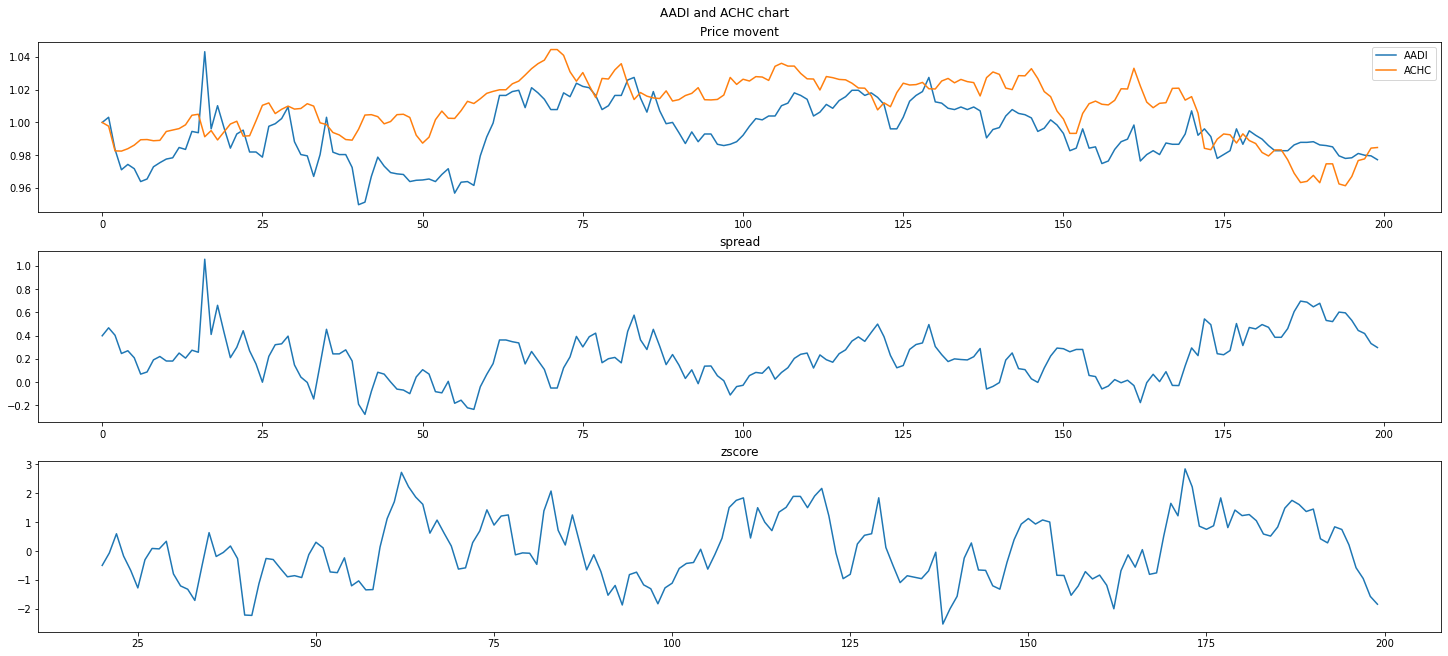

In [202]:
show_pair_report(df_cpairs, df_bars, target_element=1)

### HIDDEN MARKOV MODEL SENTIMENT ANALYSIS

### PLACING ORDERS


### TRADING SESSION


##### Ideas and notes



*   track traded pairs, add flag to them 
*   show the actual chart (based on live data) 



##### global variables

In [203]:
# traded_pairs = []

In [204]:
df_cpairs

,Unnamed: 0,sym_1,sym_2,coint_flag,p_value,t_value,c_value,hedge_ratio,zero_crossing,traded
0,235,APPS,APPF,1,0.03,-3.50,-3.37,0.14,43,0
1,11,AADI,ACHC,1,0.00,-4.32,-3.37,0.15,36,0
2,117,AMSF,ALIT,1,0.03,-3.52,-3.37,5.89,35,0
3,199,APA,AGYS,1,0.01,-4.05,-3.37,0.55,35,0
4,210,APH,AB,1,0.00,-4.64,-3.37,2.10,35,0
...,...,...,...,...,...,...,...,...,...,...
247,245,AQUA,AIZ,1,0.03,-3.56,-3.37,0.34,1,0
248,105,AMSC,AAWW,1,0.01,-3.80,-3.37,0.05,1,0
249,198,APA,AGS,1,0.01,-3.86,-3.37,7.67,1,0
250,4,AAAU,ABBV,1,0.01,-4.09,-3.37,0.12,1,0


##### handlers functions

In [205]:


def turn_pairs_traded (pairs_list, data):
  print(pairs_list)
  data.loc[(data.sym_1 == pairs_list[0][0]) &  (data.sym_2 == pairs_list[0][1]), "traded"] = 1


def save_traded_data (data):
  df_traded_assets = data.loc[lambda x: x["traded"] == 1]
  df_traded_assets.to_csv("df_traded_pairs.csv")
  print("traded asset list saved!")
  
def add_traded_pairs(sym_1, sym_2, data):
  traded_pairs = []
  traded_pairs.append([sym_1, sym_2])
  turn_pairs_traded(traded_pairs, data)
  save_traded_data(data)


In [206]:
add_traded_pairs('APPS', 'APPF', df_cpairs)
add_traded_pairs('AADI', 'ACHC', df_cpairs)
add_traded_pairs('AMSF', 'ALIT', df_cpairs)

[['APPS', 'APPF']]
traded asset list saved!
[['AADI', 'ACHC']]
traded asset list saved!
[['AMSF', 'ALIT']]
traded asset list saved!


In [207]:
df_test = pd.read_csv('/content/df_traded_pairs.csv')

In [208]:
df_test.head()

,Unnamed: 0,Unnamed: 0.1,sym_1,sym_2,coint_flag,p_value,t_value,c_value,hedge_ratio,zero_crossing,traded
0,0,235,APPS,APPF,1,0.03,-3.50,-3.37,0.14,43,1
1,1,11,AADI,ACHC,1,0.00,-4.32,-3.37,0.15,36,1
2,2,117,AMSF,ALIT,1,0.03,-3.52,-3.37,5.89,35,1
